In [1]:
import os
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
from tqdm import tqdm

In [3]:
data = np.load('/home/gauravs/exxa/1M_pos_clean_data.npy')
data.shape

(995978, 279)

In [4]:
test_ind = [1,10,100]
new_data = np.delete(data,test_ind,axis=0)
new_data.shape

(995975, 279)

---------------------------------

In [5]:
def calc_SN(spec,sigma):
    return (np.max(spec) - np.min(spec))/sigma

In [6]:
spec_data = new_data[:,:269]

SNR = []
FH = []
MT = []
for i in range(len(spec_data)):
    MT.append(np.mean(spec_data[i]))
    FH.append(np.max(spec_data[i]) - np.min(spec_data[i]))
    SNR.append(calc_SN(spec_data[i],sigma=10))

MT = np.array(MT)
FH = np.array(FH)
SNR = np.array(SNR)
MT.shape, FH.shape, SNR.shape

((995975,), (995975,), (995975,))

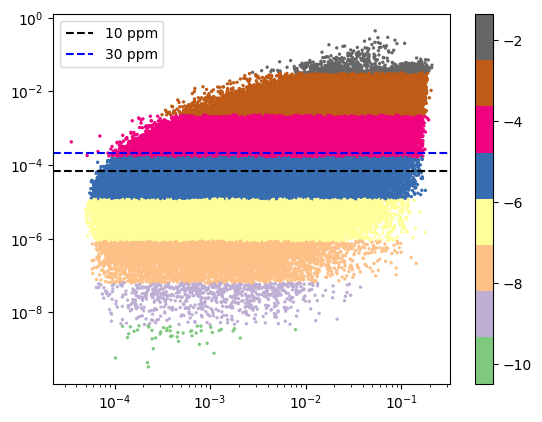

In [7]:
plt.scatter(MT,FH,c=np.log10(SNR),cmap='Accent',s=2)
plt.axhline(y=(7*10*1e-6),ls='--',label='10 ppm',color='black')
plt.axhline(y=(7*30*1e-6),ls='--',label='30 ppm',color='blue')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [8]:
# 30 ppm
cut_FH = 7*30*1e-6
cut_FH

0.00020999999999999998

In [9]:
indx = np.where(FH <= cut_FH)[0]
indx.shape

(500396,)

In [10]:
f_data = np.delete(new_data,indx,axis=0)
f_data.shape

(495579, 279)

In [11]:
def add_noise(spec,noise):
    return np.random.normal(spec,noise)

constant_noise = 10e-6
noisy_spec = np.zeros_like(f_data[:,:269])
for i in range(len(f_data)):
    noisy_spec[i] = add_noise(f_data[i,:269],constant_noise)
noisy_spec.shape

(495579, 269)

In [12]:
train_data = noisy_spec
new_spec = np.zeros_like(f_data[:,:271])
for i in range(len(train_data)):
    mean_sp = np.mean(train_data[i,:269])
    std_sp = np.std(train_data[i,:269])
    new_spec[i,:269] = (train_data[i,:269] - mean_sp) / std_sp
    new_spec[i,269] = mean_sp
    new_spec[i,270] = std_sp
#     new_spec[i,271] = tr_data[i,269]   # rstar
#     new_spec[i,272] = tr_data[i,270]   # rplanet
#     new_spec[i,273] = tr_data[i,271]   # gp
new_spec.shape

(495579, 271)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim.lr_scheduler import ExponentialLR

class GRUModel(nn.Module):
    def __init__(self ):
        super(GRUModel, self).__init__()
        self.gru1 = nn.GRU(input_size=X_train.shape[1], hidden_size=64, batch_first=True)
        self.gru2 = nn.GRU(64, hidden_size=128, num_layers=1, dropout=0.1,
                            bidirectional=False, batch_first=True)
        self.gru3 = nn.GRU(128, hidden_size=256, num_layers=1, dropout=0.1,
                            bidirectional=False, batch_first=True)
        self.gru4 = nn.GRU(256, hidden_size=128, num_layers=1, dropout=0.1,
                            bidirectional=False, batch_first=True)
        self.dense = nn.Linear(128, 7)
    
    def forward(self, x):
        x, _ = self.gru1(x)
        x, _ = self.gru2(x)
        x, _ = self.gru3(x)
        x, _ = self.gru4(x)
        x = self.dense(x)
        return x

# R^2 loss function
class R2Loss(nn.Module):
    def __init__(self):
        super(R2Loss, self).__init__()

    def forward(self, y_pred, y_true):
        ss_res = torch.sum(torch.square(y_true - y_pred))
        ss_tot = torch.sum(torch.square(y_true - torch.mean(y_true)))
        r2 = 1 - ss_res / ss_tot
        return r2

In [15]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X = new_spec
Y = f_data[:,272:]
print(X.shape, Y.shape)

scaler = StandardScaler()
Y = scaler.fit_transform(Y)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)


X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

(495579, 271) (495579, 7)
(396463, 271) (396463, 7) (99116, 271) (99116, 7)


In [16]:
# Initialize the model
model = GRUModel()
input_size = (1,X_train.shape[1])
summary(model, input_size)

/home/gauravs/anaconda3/envs/astro/lib/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Layer (type:depth-idx)                   Output Shape              Param #
GRUModel                                 [1, 7]                    --
├─GRU: 1-1                               [1, 64]                   64,704
├─GRU: 1-2                               [1, 128]                  74,496
├─GRU: 1-3                               [1, 256]                  296,448
├─GRU: 1-4                               [1, 128]                  148,224
├─Linear: 1-5                            [1, 7]                    903
Total params: 584,775
Trainable params: 584,775
Non-trainable params: 0
Total mult-adds (M): 108.54
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 2.34
Estimated Total Size (MB): 2.34

In [17]:
# Print model architecture
print(model)

GRUModel(
  (gru1): GRU(271, 64, batch_first=True)
  (gru2): GRU(64, 128, batch_first=True, dropout=0.1)
  (gru3): GRU(128, 256, batch_first=True, dropout=0.1)
  (gru4): GRU(256, 128, batch_first=True, dropout=0.1)
  (dense): Linear(in_features=128, out_features=7, bias=True)
)


In [18]:
initial_learning_rate = 1e-3
final_learning_rate = 1e-5
epochs = 100
train_size = X_train.shape[0]
batch_size = 32
lr_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = int(train_size/batch_size)
lr_decay_factor, steps_per_epoch

(0.954992586021436, 12389)

In [19]:
# Loss function and optimizer
criterion = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ExponentialLR(optimizer,gamma=lr_decay_factor)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Training loop
epochs = 100

losses = []
r2s = []
test_losses = []
test_r2s = []
cur_lrs =[]
for epoch in range(epochs):
    model.train()  
    running_loss = 0.0
    running_r2 = 0.0
    for i, (inputs, targets) in tqdm(enumerate(train_loader, 0),total=len(train_loader), desc=f'[Epoch {epoch+1}/{epochs}]'):
        
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs, targets)
        r2 = R2Loss()(outputs, targets)
 
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_r2 += r2.item()
        
    losses.append(running_loss / len(train_loader))
    r2s.append(running_r2 / len(train_loader))
    
    # Testing the model
    model.eval()  
    test_loss = 0.0
    test_r2 = 0.0
    with torch.no_grad():  
        for inputs, targets in test_loader:
            
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, targets)
            r2 = R2Loss()(outputs, targets)

            test_loss += loss.item()
            test_r2 += r2.item()
            
    # Average test loss
    avg_test_loss = test_loss / len(test_loader)
    avg_test_r2 = test_r2 / len(test_loader)
    test_losses.append(avg_test_loss)
    test_r2s.append(avg_test_r2)
    print(f'Epoch [{epoch+1}/{epochs}] Train Loss: {running_loss / len(train_loader):.3f}, Train R2: {running_r2/len(train_loader):.3f}, Test Loss: {avg_test_loss:.3f}, Test R2: {avg_test_r2:.3f}')
    
    current_lr = optimizer.param_groups[0]['lr']
    cur_lrs.append(current_lr)   
    scheduler.step()
    
    
print()
print('!!!Training complete!!!')
print()


[Epoch 1/100]: 100%|██████████| 12390/12390 [03:49<00:00, 54.02it/s]


Epoch [1/100] Train Loss: 0.211, Train R2: 0.788, Test Loss: 0.176, Test R2: 0.823


[Epoch 2/100]: 100%|██████████| 12390/12390 [03:48<00:00, 54.32it/s]


Epoch [2/100] Train Loss: 0.166, Train R2: 0.833, Test Loss: 0.156, Test R2: 0.844


[Epoch 3/100]: 100%|██████████| 12390/12390 [03:49<00:00, 54.04it/s]


Epoch [3/100] Train Loss: 0.157, Train R2: 0.842, Test Loss: 0.159, Test R2: 0.841


[Epoch 4/100]: 100%|██████████| 12390/12390 [03:43<00:00, 55.55it/s]


Epoch [4/100] Train Loss: 0.153, Train R2: 0.847, Test Loss: 0.147, Test R2: 0.853


[Epoch 5/100]: 100%|██████████| 12390/12390 [03:49<00:00, 54.04it/s]


Epoch [5/100] Train Loss: 0.149, Train R2: 0.850, Test Loss: 0.149, Test R2: 0.851


[Epoch 6/100]: 100%|██████████| 12390/12390 [03:45<00:00, 54.96it/s]


Epoch [6/100] Train Loss: 0.146, Train R2: 0.853, Test Loss: 0.143, Test R2: 0.856


[Epoch 7/100]: 100%|██████████| 12390/12390 [03:49<00:00, 53.89it/s]


Epoch [7/100] Train Loss: 0.144, Train R2: 0.855, Test Loss: 0.149, Test R2: 0.850


[Epoch 8/100]: 100%|██████████| 12390/12390 [03:48<00:00, 54.24it/s]


Epoch [8/100] Train Loss: 0.142, Train R2: 0.857, Test Loss: 0.148, Test R2: 0.851


[Epoch 9/100]: 100%|██████████| 12390/12390 [03:47<00:00, 54.57it/s]


Epoch [9/100] Train Loss: 0.140, Train R2: 0.859, Test Loss: 0.145, Test R2: 0.854


[Epoch 10/100]: 100%|██████████| 12390/12390 [03:48<00:00, 54.13it/s]


Epoch [10/100] Train Loss: 0.139, Train R2: 0.861, Test Loss: 0.139, Test R2: 0.860


[Epoch 11/100]: 100%|██████████| 12390/12390 [03:49<00:00, 53.98it/s]


Epoch [11/100] Train Loss: 0.137, Train R2: 0.862, Test Loss: 0.141, Test R2: 0.858


[Epoch 12/100]: 100%|██████████| 12390/12390 [03:48<00:00, 54.23it/s]


Epoch [12/100] Train Loss: 0.136, Train R2: 0.863, Test Loss: 0.138, Test R2: 0.862


[Epoch 13/100]: 100%|██████████| 12390/12390 [03:41<00:00, 55.88it/s]


Epoch [13/100] Train Loss: 0.135, Train R2: 0.865, Test Loss: 0.139, Test R2: 0.860


[Epoch 14/100]: 100%|██████████| 12390/12390 [03:48<00:00, 54.32it/s]


Epoch [14/100] Train Loss: 0.133, Train R2: 0.866, Test Loss: 0.137, Test R2: 0.863


[Epoch 15/100]: 100%|██████████| 12390/12390 [03:41<00:00, 55.95it/s]


Epoch [15/100] Train Loss: 0.132, Train R2: 0.867, Test Loss: 0.138, Test R2: 0.862


[Epoch 16/100]: 100%|██████████| 12390/12390 [03:23<00:00, 60.74it/s]


Epoch [16/100] Train Loss: 0.131, Train R2: 0.868, Test Loss: 0.136, Test R2: 0.863


[Epoch 17/100]: 100%|██████████| 12390/12390 [03:23<00:00, 60.91it/s]


Epoch [17/100] Train Loss: 0.130, Train R2: 0.869, Test Loss: 0.132, Test R2: 0.868


[Epoch 18/100]: 100%|██████████| 12390/12390 [03:47<00:00, 54.49it/s]


Epoch [18/100] Train Loss: 0.129, Train R2: 0.870, Test Loss: 0.135, Test R2: 0.864


[Epoch 19/100]: 100%|██████████| 12390/12390 [03:49<00:00, 54.05it/s]


Epoch [19/100] Train Loss: 0.128, Train R2: 0.871, Test Loss: 0.132, Test R2: 0.868


[Epoch 20/100]: 100%|██████████| 12390/12390 [03:49<00:00, 54.07it/s]


Epoch [20/100] Train Loss: 0.127, Train R2: 0.872, Test Loss: 0.136, Test R2: 0.864


[Epoch 21/100]: 100%|██████████| 12390/12390 [03:49<00:00, 54.05it/s]


Epoch [21/100] Train Loss: 0.127, Train R2: 0.873, Test Loss: 0.133, Test R2: 0.867


[Epoch 22/100]: 100%|██████████| 12390/12390 [03:48<00:00, 54.29it/s]


Epoch [22/100] Train Loss: 0.126, Train R2: 0.874, Test Loss: 0.132, Test R2: 0.867


[Epoch 23/100]: 100%|██████████| 12390/12390 [03:48<00:00, 54.15it/s]


Epoch [23/100] Train Loss: 0.125, Train R2: 0.874, Test Loss: 0.132, Test R2: 0.868


[Epoch 24/100]: 100%|██████████| 12390/12390 [03:48<00:00, 54.27it/s]


Epoch [24/100] Train Loss: 0.124, Train R2: 0.875, Test Loss: 0.137, Test R2: 0.863


[Epoch 25/100]: 100%|██████████| 12390/12390 [03:44<00:00, 55.13it/s]


Epoch [25/100] Train Loss: 0.124, Train R2: 0.876, Test Loss: 0.129, Test R2: 0.871


[Epoch 26/100]: 100%|██████████| 12390/12390 [03:48<00:00, 54.13it/s]


Epoch [26/100] Train Loss: 0.123, Train R2: 0.876, Test Loss: 0.130, Test R2: 0.870


[Epoch 27/100]: 100%|██████████| 12390/12390 [03:49<00:00, 54.09it/s]


Epoch [27/100] Train Loss: 0.122, Train R2: 0.877, Test Loss: 0.128, Test R2: 0.872


[Epoch 28/100]: 100%|██████████| 12390/12390 [03:48<00:00, 54.28it/s]


Epoch [28/100] Train Loss: 0.122, Train R2: 0.878, Test Loss: 0.128, Test R2: 0.872


[Epoch 29/100]: 100%|██████████| 12390/12390 [03:49<00:00, 53.93it/s]


Epoch [29/100] Train Loss: 0.121, Train R2: 0.878, Test Loss: 0.127, Test R2: 0.873


[Epoch 30/100]: 100%|██████████| 12390/12390 [03:38<00:00, 56.69it/s]


Epoch [30/100] Train Loss: 0.121, Train R2: 0.879, Test Loss: 0.128, Test R2: 0.871


[Epoch 31/100]: 100%|██████████| 12390/12390 [03:48<00:00, 54.30it/s]


Epoch [31/100] Train Loss: 0.120, Train R2: 0.879, Test Loss: 0.127, Test R2: 0.872


[Epoch 32/100]: 100%|██████████| 12390/12390 [03:48<00:00, 54.29it/s]


Epoch [32/100] Train Loss: 0.119, Train R2: 0.880, Test Loss: 0.125, Test R2: 0.874


[Epoch 33/100]: 100%|██████████| 12390/12390 [03:49<00:00, 54.05it/s]


Epoch [33/100] Train Loss: 0.119, Train R2: 0.880, Test Loss: 0.126, Test R2: 0.873


[Epoch 34/100]: 100%|██████████| 12390/12390 [03:47<00:00, 54.55it/s]


Epoch [34/100] Train Loss: 0.118, Train R2: 0.881, Test Loss: 0.125, Test R2: 0.875


[Epoch 35/100]: 100%|██████████| 12390/12390 [03:50<00:00, 53.79it/s]


Epoch [35/100] Train Loss: 0.118, Train R2: 0.881, Test Loss: 0.124, Test R2: 0.876


[Epoch 36/100]: 100%|██████████| 12390/12390 [03:48<00:00, 54.20it/s]


Epoch [36/100] Train Loss: 0.117, Train R2: 0.882, Test Loss: 0.125, Test R2: 0.874


[Epoch 37/100]: 100%|██████████| 12390/12390 [03:48<00:00, 54.11it/s]


Epoch [37/100] Train Loss: 0.117, Train R2: 0.882, Test Loss: 0.125, Test R2: 0.875


[Epoch 38/100]: 100%|██████████| 12390/12390 [03:38<00:00, 56.65it/s]


Epoch [38/100] Train Loss: 0.117, Train R2: 0.883, Test Loss: 0.127, Test R2: 0.873


[Epoch 39/100]: 100%|██████████| 12390/12390 [03:48<00:00, 54.28it/s]


Epoch [39/100] Train Loss: 0.116, Train R2: 0.883, Test Loss: 0.123, Test R2: 0.876


[Epoch 40/100]: 100%|██████████| 12390/12390 [03:48<00:00, 54.30it/s]


Epoch [40/100] Train Loss: 0.116, Train R2: 0.884, Test Loss: 0.123, Test R2: 0.876


[Epoch 41/100]: 100%|██████████| 12390/12390 [03:46<00:00, 54.67it/s]


Epoch [41/100] Train Loss: 0.115, Train R2: 0.884, Test Loss: 0.122, Test R2: 0.877


[Epoch 42/100]: 100%|██████████| 12390/12390 [03:47<00:00, 54.54it/s]


Epoch [42/100] Train Loss: 0.115, Train R2: 0.884, Test Loss: 0.123, Test R2: 0.876


[Epoch 43/100]: 100%|██████████| 12390/12390 [03:47<00:00, 54.35it/s]


Epoch [43/100] Train Loss: 0.115, Train R2: 0.885, Test Loss: 0.123, Test R2: 0.876


[Epoch 44/100]: 100%|██████████| 12390/12390 [03:47<00:00, 54.46it/s]


Epoch [44/100] Train Loss: 0.114, Train R2: 0.885, Test Loss: 0.123, Test R2: 0.877


[Epoch 45/100]: 100%|██████████| 12390/12390 [03:49<00:00, 54.06it/s]


Epoch [45/100] Train Loss: 0.114, Train R2: 0.885, Test Loss: 0.121, Test R2: 0.878


[Epoch 46/100]: 100%|██████████| 12390/12390 [03:46<00:00, 54.72it/s]


Epoch [46/100] Train Loss: 0.114, Train R2: 0.886, Test Loss: 0.122, Test R2: 0.877


[Epoch 47/100]: 100%|██████████| 12390/12390 [03:13<00:00, 64.12it/s]


Epoch [47/100] Train Loss: 0.113, Train R2: 0.886, Test Loss: 0.121, Test R2: 0.879


[Epoch 48/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.60it/s]


Epoch [48/100] Train Loss: 0.113, Train R2: 0.886, Test Loss: 0.122, Test R2: 0.878


[Epoch 49/100]: 100%|██████████| 12390/12390 [02:57<00:00, 69.63it/s]


Epoch [49/100] Train Loss: 0.113, Train R2: 0.887, Test Loss: 0.122, Test R2: 0.878


[Epoch 50/100]: 100%|██████████| 12390/12390 [02:57<00:00, 69.67it/s]


Epoch [50/100] Train Loss: 0.113, Train R2: 0.887, Test Loss: 0.121, Test R2: 0.879


[Epoch 51/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.43it/s]


Epoch [51/100] Train Loss: 0.112, Train R2: 0.887, Test Loss: 0.121, Test R2: 0.879


[Epoch 52/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.53it/s]


Epoch [52/100] Train Loss: 0.112, Train R2: 0.887, Test Loss: 0.121, Test R2: 0.879


[Epoch 53/100]: 100%|██████████| 12390/12390 [02:46<00:00, 74.24it/s]


Epoch [53/100] Train Loss: 0.112, Train R2: 0.888, Test Loss: 0.121, Test R2: 0.879


[Epoch 54/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.33it/s]


Epoch [54/100] Train Loss: 0.112, Train R2: 0.888, Test Loss: 0.122, Test R2: 0.878


[Epoch 55/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.51it/s]


Epoch [55/100] Train Loss: 0.111, Train R2: 0.888, Test Loss: 0.120, Test R2: 0.879


[Epoch 56/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.42it/s]


Epoch [56/100] Train Loss: 0.111, Train R2: 0.888, Test Loss: 0.121, Test R2: 0.879


[Epoch 57/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.53it/s]


Epoch [57/100] Train Loss: 0.111, Train R2: 0.888, Test Loss: 0.120, Test R2: 0.880


[Epoch 58/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.58it/s]


Epoch [58/100] Train Loss: 0.111, Train R2: 0.889, Test Loss: 0.120, Test R2: 0.879


[Epoch 59/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.59it/s]


Epoch [59/100] Train Loss: 0.111, Train R2: 0.889, Test Loss: 0.120, Test R2: 0.879


[Epoch 60/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.44it/s]


Epoch [60/100] Train Loss: 0.110, Train R2: 0.889, Test Loss: 0.120, Test R2: 0.880


[Epoch 61/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.57it/s]


Epoch [61/100] Train Loss: 0.110, Train R2: 0.889, Test Loss: 0.120, Test R2: 0.880


[Epoch 62/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.58it/s]


Epoch [62/100] Train Loss: 0.110, Train R2: 0.889, Test Loss: 0.120, Test R2: 0.879


[Epoch 63/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.51it/s]


Epoch [63/100] Train Loss: 0.110, Train R2: 0.889, Test Loss: 0.119, Test R2: 0.880


[Epoch 64/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.22it/s]


Epoch [64/100] Train Loss: 0.110, Train R2: 0.890, Test Loss: 0.119, Test R2: 0.880


[Epoch 65/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.24it/s]


Epoch [65/100] Train Loss: 0.110, Train R2: 0.890, Test Loss: 0.119, Test R2: 0.880


[Epoch 66/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.58it/s]


Epoch [66/100] Train Loss: 0.110, Train R2: 0.890, Test Loss: 0.119, Test R2: 0.880


[Epoch 67/100]: 100%|██████████| 12390/12390 [02:57<00:00, 69.61it/s]


Epoch [67/100] Train Loss: 0.109, Train R2: 0.890, Test Loss: 0.120, Test R2: 0.880


[Epoch 68/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.42it/s]


Epoch [68/100] Train Loss: 0.109, Train R2: 0.890, Test Loss: 0.120, Test R2: 0.880


[Epoch 69/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.59it/s]


Epoch [69/100] Train Loss: 0.109, Train R2: 0.890, Test Loss: 0.119, Test R2: 0.880


[Epoch 70/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.44it/s]


Epoch [70/100] Train Loss: 0.109, Train R2: 0.890, Test Loss: 0.119, Test R2: 0.881


[Epoch 71/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.60it/s]


Epoch [71/100] Train Loss: 0.109, Train R2: 0.891, Test Loss: 0.119, Test R2: 0.881


[Epoch 72/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.60it/s]


Epoch [72/100] Train Loss: 0.109, Train R2: 0.891, Test Loss: 0.119, Test R2: 0.881


[Epoch 73/100]: 100%|██████████| 12390/12390 [02:57<00:00, 69.72it/s]


Epoch [73/100] Train Loss: 0.109, Train R2: 0.891, Test Loss: 0.119, Test R2: 0.881


[Epoch 74/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.54it/s]


Epoch [74/100] Train Loss: 0.109, Train R2: 0.891, Test Loss: 0.119, Test R2: 0.881


[Epoch 75/100]: 100%|██████████| 12390/12390 [02:57<00:00, 69.83it/s]


Epoch [75/100] Train Loss: 0.109, Train R2: 0.891, Test Loss: 0.119, Test R2: 0.881


[Epoch 76/100]: 100%|██████████| 12390/12390 [02:57<00:00, 69.61it/s]


Epoch [76/100] Train Loss: 0.108, Train R2: 0.891, Test Loss: 0.119, Test R2: 0.881


[Epoch 77/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.45it/s]


Epoch [77/100] Train Loss: 0.108, Train R2: 0.891, Test Loss: 0.119, Test R2: 0.881


[Epoch 78/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.39it/s]


Epoch [78/100] Train Loss: 0.108, Train R2: 0.891, Test Loss: 0.119, Test R2: 0.881


[Epoch 79/100]: 100%|██████████| 12390/12390 [02:39<00:00, 77.73it/s] 


Epoch [79/100] Train Loss: 0.108, Train R2: 0.891, Test Loss: 0.119, Test R2: 0.881


[Epoch 80/100]: 100%|██████████| 12390/12390 [02:37<00:00, 78.65it/s]


Epoch [80/100] Train Loss: 0.108, Train R2: 0.891, Test Loss: 0.119, Test R2: 0.881


[Epoch 81/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.60it/s]


Epoch [81/100] Train Loss: 0.108, Train R2: 0.891, Test Loss: 0.119, Test R2: 0.881


[Epoch 82/100]: 100%|██████████| 12390/12390 [02:57<00:00, 69.67it/s]


Epoch [82/100] Train Loss: 0.108, Train R2: 0.891, Test Loss: 0.119, Test R2: 0.881


[Epoch 83/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.44it/s]


Epoch [83/100] Train Loss: 0.108, Train R2: 0.892, Test Loss: 0.118, Test R2: 0.881


[Epoch 84/100]: 100%|██████████| 12390/12390 [02:57<00:00, 69.62it/s]


Epoch [84/100] Train Loss: 0.108, Train R2: 0.892, Test Loss: 0.118, Test R2: 0.881


[Epoch 85/100]: 100%|██████████| 12390/12390 [02:57<00:00, 69.67it/s]


Epoch [85/100] Train Loss: 0.108, Train R2: 0.892, Test Loss: 0.119, Test R2: 0.881


[Epoch 86/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.56it/s]


Epoch [86/100] Train Loss: 0.108, Train R2: 0.892, Test Loss: 0.119, Test R2: 0.881


[Epoch 87/100]: 100%|██████████| 12390/12390 [02:57<00:00, 69.70it/s]


Epoch [87/100] Train Loss: 0.108, Train R2: 0.892, Test Loss: 0.119, Test R2: 0.881


[Epoch 88/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.55it/s]


Epoch [88/100] Train Loss: 0.108, Train R2: 0.892, Test Loss: 0.118, Test R2: 0.881


[Epoch 89/100]: 100%|██████████| 12390/12390 [02:57<00:00, 69.68it/s]


Epoch [89/100] Train Loss: 0.108, Train R2: 0.892, Test Loss: 0.118, Test R2: 0.881


[Epoch 90/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.36it/s]


Epoch [90/100] Train Loss: 0.108, Train R2: 0.892, Test Loss: 0.118, Test R2: 0.881


[Epoch 91/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.31it/s]


Epoch [91/100] Train Loss: 0.107, Train R2: 0.892, Test Loss: 0.119, Test R2: 0.881


[Epoch 92/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.38it/s]


Epoch [92/100] Train Loss: 0.107, Train R2: 0.892, Test Loss: 0.118, Test R2: 0.881


[Epoch 93/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.46it/s]


Epoch [93/100] Train Loss: 0.107, Train R2: 0.892, Test Loss: 0.118, Test R2: 0.881


[Epoch 94/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.58it/s]


Epoch [94/100] Train Loss: 0.107, Train R2: 0.892, Test Loss: 0.119, Test R2: 0.881


[Epoch 95/100]: 100%|██████████| 12390/12390 [02:57<00:00, 69.89it/s]


Epoch [95/100] Train Loss: 0.107, Train R2: 0.892, Test Loss: 0.118, Test R2: 0.881


[Epoch 96/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.56it/s]


Epoch [96/100] Train Loss: 0.107, Train R2: 0.892, Test Loss: 0.118, Test R2: 0.881


[Epoch 97/100]: 100%|██████████| 12390/12390 [02:58<00:00, 69.51it/s]


Epoch [97/100] Train Loss: 0.107, Train R2: 0.892, Test Loss: 0.118, Test R2: 0.881


[Epoch 98/100]: 100%|██████████| 12390/12390 [02:57<00:00, 69.83it/s]


Epoch [98/100] Train Loss: 0.107, Train R2: 0.892, Test Loss: 0.118, Test R2: 0.882


[Epoch 99/100]: 100%|██████████| 12390/12390 [02:57<00:00, 69.83it/s]


Epoch [99/100] Train Loss: 0.107, Train R2: 0.892, Test Loss: 0.118, Test R2: 0.881


[Epoch 100/100]: 100%|██████████| 12390/12390 [02:57<00:00, 69.87it/s]


Epoch [100/100] Train Loss: 0.107, Train R2: 0.892, Test Loss: 0.118, Test R2: 0.881

!!!Training complete!!!



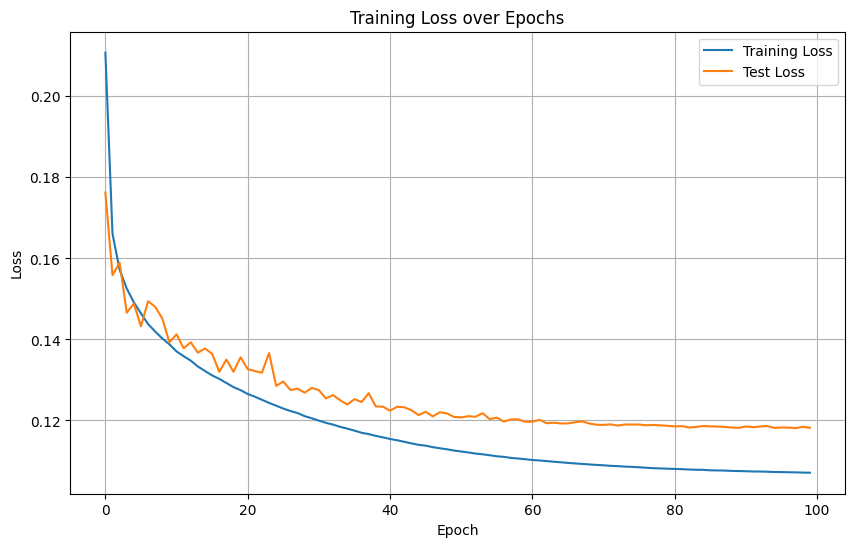

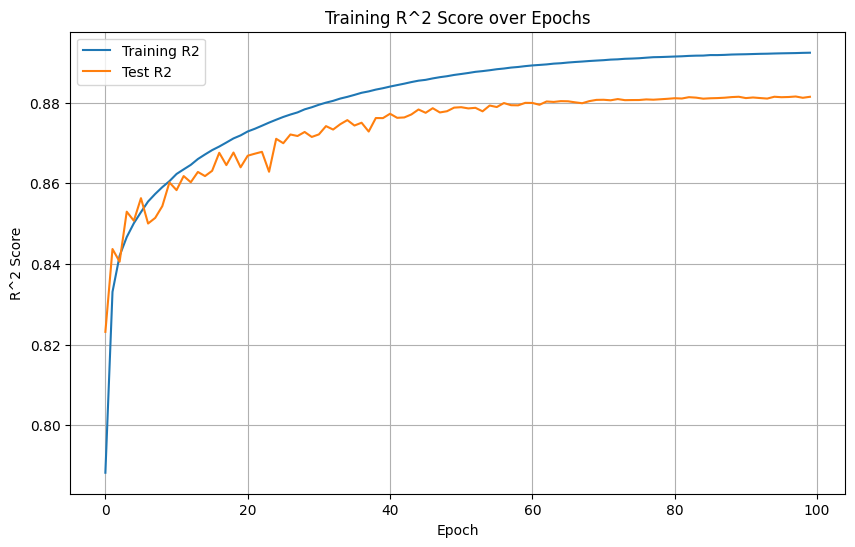

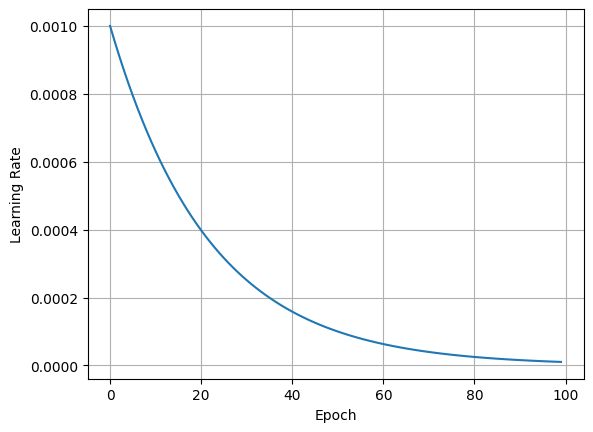

In [20]:
# Plotting the losses after training
plt.figure(figsize=(10, 6))
plt.plot( losses, label='Training Loss')
plt.plot( test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the R2 Score after training
plt.figure(figsize=(10, 6))
plt.plot( r2s, label='Training R2')
plt.plot( test_r2s, label='Test R2')
plt.xlabel('Epoch')
plt.ylabel('R^2 Score')
plt.title('Training R^2 Score over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the learning rate 
plt.plot( cur_lrs)
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()


In [21]:
path = '/home/gauravs/exxa/gru/torch-gru_noisy'
torch.save(model,path)
print(f'Model saved at {path}')
print()

Model saved at /home/gauravs/exxa/gru/torch-gru_noisy



-------------------------------

In [22]:
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # Predict outputs
        outputs = model(inputs)
        
        y_pred.append(outputs.cpu().numpy())  # Move predictions back to CPU and store
        y_true.append(targets.cpu().numpy())  # Store the true values

# Concatenate all the batches into one array
y_pred = np.concatenate(y_pred, axis=0)  # Shape: (2000, 7)
y_true = np.concatenate(y_true, axis=0)  # Shape: (2000, 7)

In [23]:
y_true_re = scaler.inverse_transform(y_true)
y_pred_re = scaler.inverse_transform(y_pred)

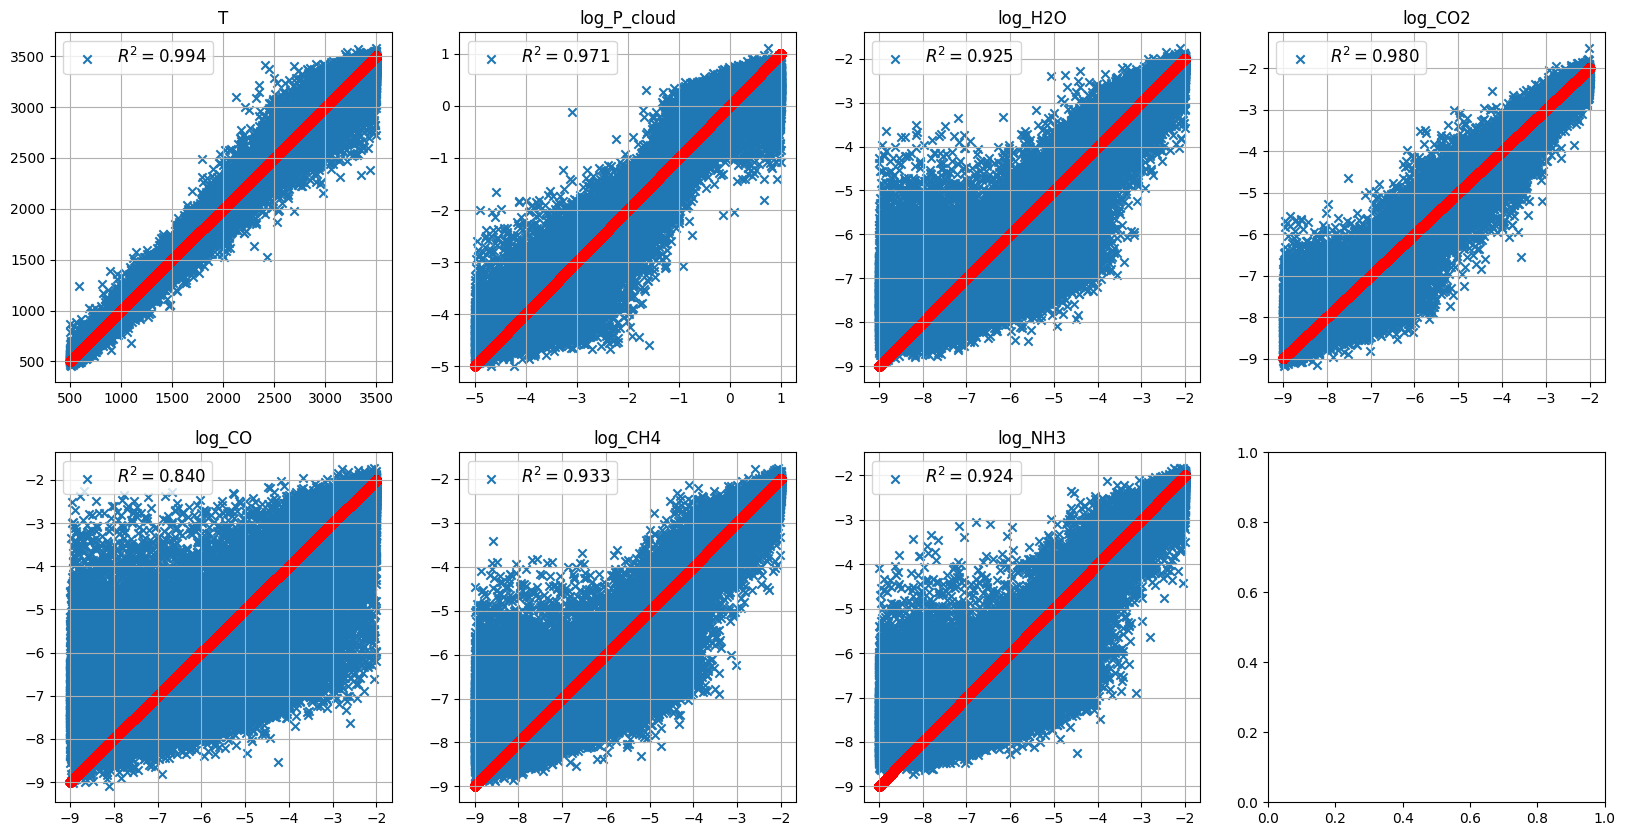

In [24]:
from scipy.stats import pearsonr
keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))
for i in range(7):
    if i < 4:
        corr, _ = pearsonr(y_pred_re [:,i], y_true_re[:,i])
        axs[0,i].scatter(y_true_re[:,i],y_pred_re [:,i], marker='x', label=f'$R^{2} = ${corr:.3f}')
        axs[0,i].scatter(y_true_re[:,i],y_true_re[:,i], color='red')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend(loc='upper left',fontsize=12)
        axs[0,i].grid()
    else:
        corr, _ = pearsonr(y_pred_re [:,i], y_true_re[:,i])
        axs[1,i-4].scatter(y_true_re[:,i],y_pred_re [:,i], marker='x', label=f'$R^{2} = ${corr:.3f}')
        axs[1,i-4].scatter(y_true_re[:,i],y_true_re[:,i], color='red')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend(loc= 'upper left',fontsize=12)
        axs[1,i-4].grid()

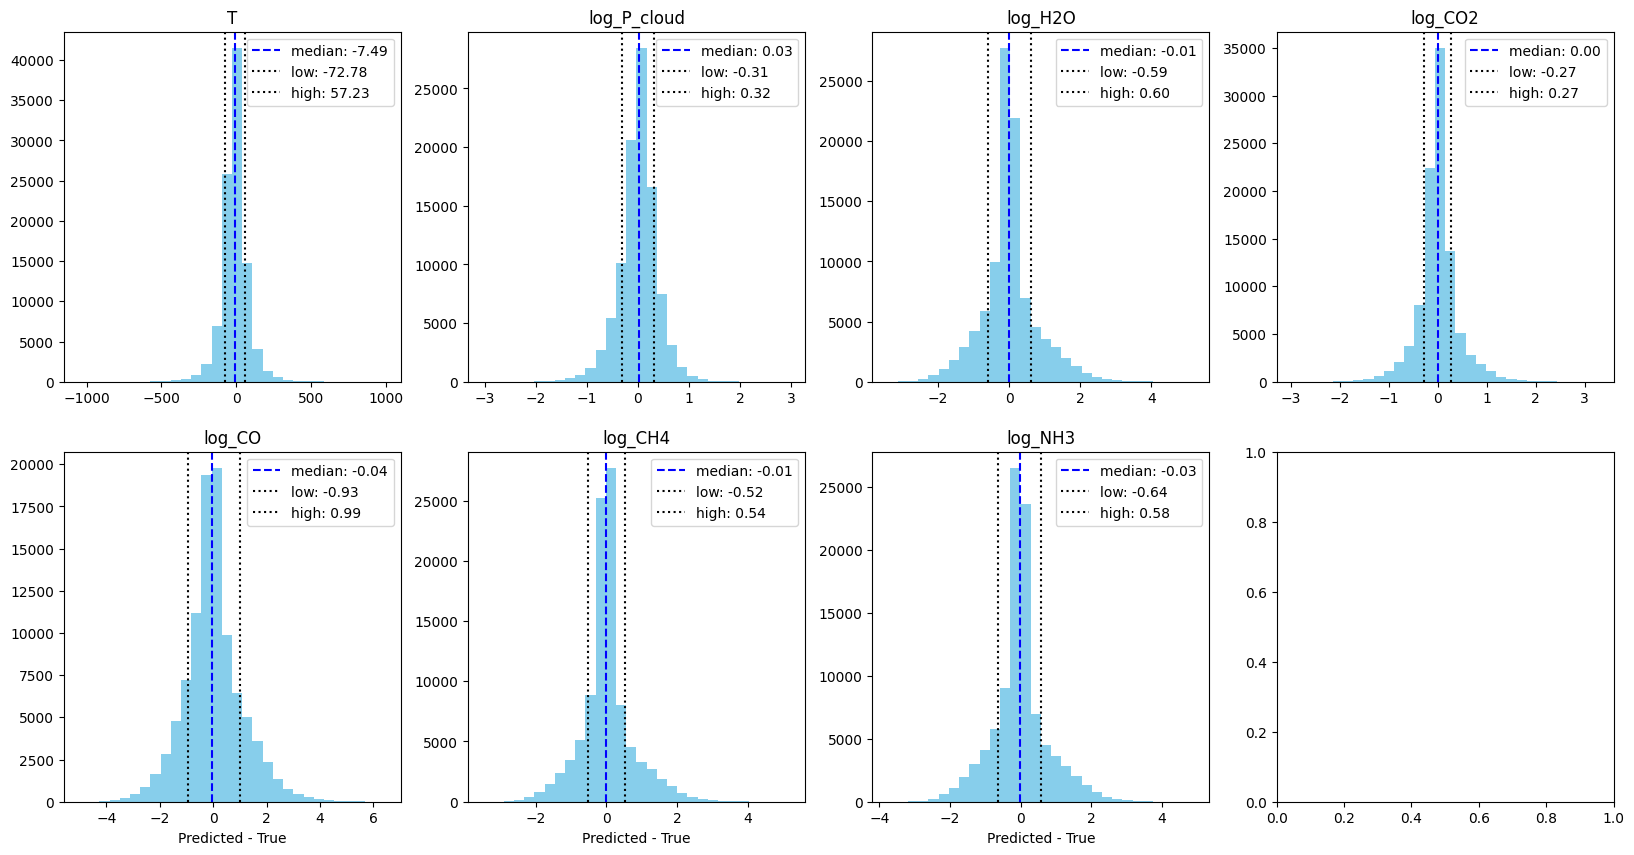

In [25]:
keys = ['T', 'log_P_cloud', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']
fig, axs = plt.subplots(2, 4, figsize=(20,10))

for i in range(7):
    if i < 4:
        pred_err = y_pred_re[:,i]-y_true_re[:,i]
        med = np.median(pred_err)
        low = np.percentile(pred_err,15.9)
        high = np.percentile(pred_err,84.1)
        axs[0,i].hist(pred_err,bins=30,color='skyblue')
        axs[0,i].axvline(x=med,color='blue',linestyle='--',label=f'median: {med:.2f}')
        axs[0,i].axvline(x=low,color='black',linestyle=':',label=f'low: {low:.2f}')
        axs[0,i].axvline(x=high,color='black',linestyle=':',label=f'high: {high:.2f}')
        axs[0,i].set_title(keys[i])
        axs[0,i].legend()
        #axs[0,i].set_xlabel('Predicted - True')
    else:
        pred_err = y_pred_re[:,i]-y_true_re[:,i]
        med = np.median(pred_err)
        low = np.percentile(pred_err,15.9)
        high = np.percentile(pred_err,84.1)
        axs[1,i-4].hist(pred_err,bins=30,color='skyblue')
        axs[1,i-4].axvline(x=med,color='blue',linestyle='--',label=f'median: {med:.2f}')
        axs[1,i-4].axvline(x=low,color='black',linestyle=':',label=f'low: {low:.2f}')
        axs[1,i-4].axvline(x=high,color='black',linestyle=':',label=f'high: {high:.2f}')
        axs[1,i-4].set_title(keys[i])
        axs[1,i-4].legend()
        axs[1,i-4].set_xlabel('Predicted - True')

------------------------------------------------

## Testing on the retreived planets

In [26]:
file_data = np.load('/home/gauravs/exxa/1M_pos_clean_data.npy')

In [27]:
mean = np.mean(file_data[1,:269])
std = np.std(file_data[1,:269])
planetA_spec = (file_data[1,:269] - mean) / std
FH = np.max(file_data[1,:269]) - np.min(file_data[1,:269])
planetA_spec = np.concatenate([planetA_spec,np.array([mean]),np.array([std])])
#planetA_spec = np.concatenate([planetA_spec,np.array([mean]),np.array([std]),np.array([file_data[1,269]]), np.array([file_data[1,270]]), np.array([file_data[1,271]])])
planetA_params = file_data[1,269:]
planetA_spec.shape, planetA_params.shape

((271,), (10,))

In [28]:
mean = np.mean(file_data[10,:269])
std = np.std(file_data[10,:269])
planetB_spec = (file_data[10,:269] - mean) / std
FH = np.max(file_data[10,:269]) - np.min(file_data[10,:269])
planetB_spec = np.concatenate([planetB_spec,np.array([mean]),np.array([std])])
#planetB_spec = np.concatenate([planetB_spec,np.array([mean]),np.array([std]),np.array([file_data[10,269]]), np.array([file_data[10,270]]), np.array([file_data[10,271]])])
planetB_params = file_data[10,269:]
planetB_spec.shape, planetB_params.shape

((271,), (10,))

In [29]:
mean = np.mean(file_data[100,:269])
std = np.std(file_data[100,:269])
planetC_spec = (file_data[100,:269] - mean) / std
FH = np.max(file_data[100,:269]) - np.min(file_data[100,:269])
planetC_spec = np.concatenate([planetC_spec,np.array([mean]),np.array([std])])
#planetC_spec = np.concatenate([planetC_spec,np.array([mean]),np.array([std]),np.array([file_data[100,269]]), np.array([file_data[100,270]]), np.array([file_data[100,271]])])
planetC_params = file_data[100,269:]
planetC_spec.shape, planetC_params.shape

((271,), (10,))

In [32]:
test_planets = np.array([planetA_spec,planetB_spec,planetC_spec])
# test_planets = test_planets.reshape(3,271,1)
test_planets.shape

(3, 271)

In [33]:
pred_data = torch.from_numpy(test_planets).float()
with torch.no_grad():
    pred_inputs = pred_data.to(device)
    # Predict outputs
    outputs = model(pred_inputs)
    pred = outputs
    
pred = np.array(pred.cpu())    
pred.shape

(3, 7)

In [34]:
pred = scaler.inverse_transform(pred)
pred

array([[ 2.0900947e+03,  2.2516976e-01, -7.4817910e+00, -8.1999445e+00,
        -4.8210735e+00, -3.4975104e+00, -4.0314488e+00],
       [ 1.0998234e+03,  2.9603302e-01, -2.6882312e+00, -2.9650724e+00,
        -6.9724774e+00, -6.1267629e+00, -5.1770916e+00],
       [ 2.6308335e+03, -3.4251595e+00, -6.8741655e+00, -5.4594121e+00,
        -7.3087959e+00, -3.1494918e+00, -6.9673505e+00]], dtype=float32)

In [35]:
planetA_pred = pred[0]
print("Predicted values:",planetA_pred)
print("Actual values:",planetA_params[3:])

Predicted values: [ 2.0900947e+03  2.2516976e-01 -7.4817910e+00 -8.1999445e+00
 -4.8210735e+00 -3.4975104e+00 -4.0314488e+00]
Actual values: [ 2.08383676e+03 -1.94865038e-01 -7.35204337e+00 -8.11423364e+00
 -5.01872241e+00 -3.65232765e+00 -4.16874130e+00]


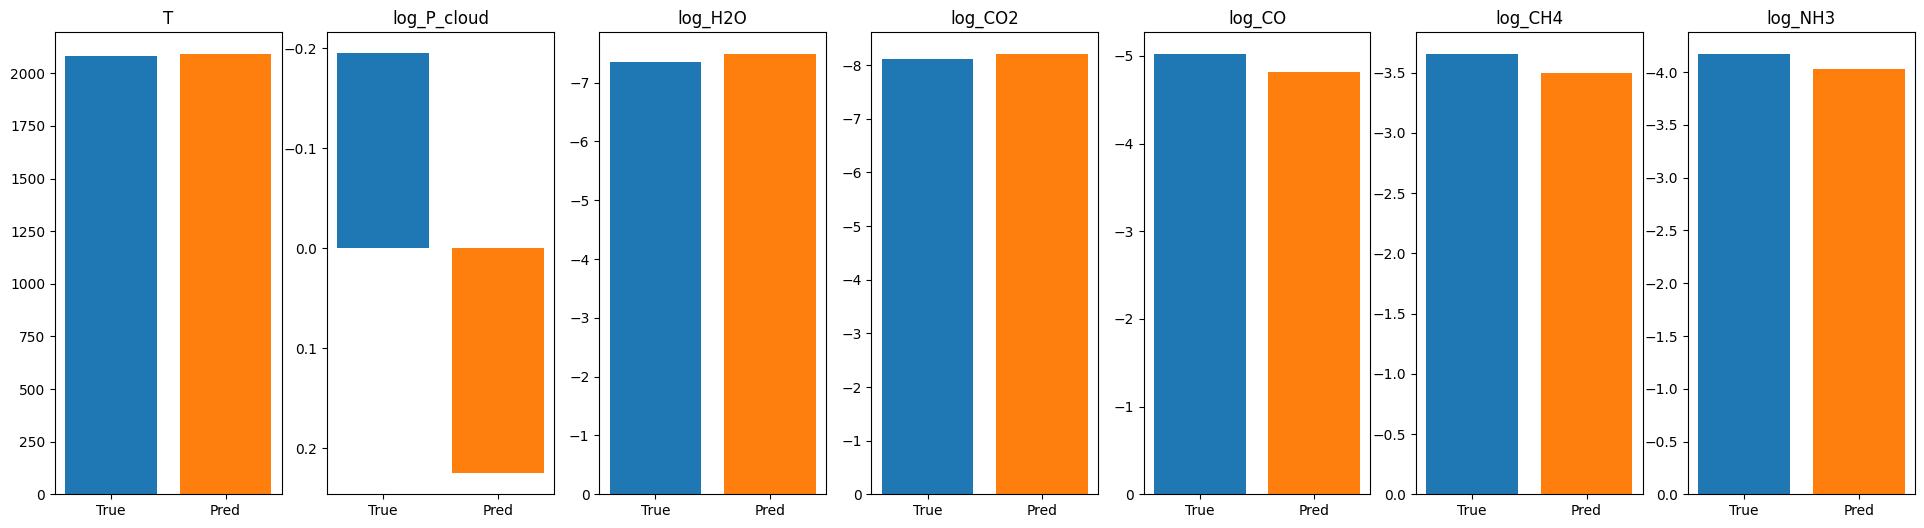

In [36]:
labels1 = ['True']
labels2 = ['Pred']
fig, axs = plt.subplots(1, 7, figsize=(24,6))

for i in range(7):
    if i > 0:
        axs[i].bar(labels1, planetA_params[3+i])
        axs[i].bar(labels2, planetA_pred[i])
        
        axs[i].set_title(keys[i])
        axs[i].invert_yaxis()
    else:
        axs[i].bar(labels1, planetA_params[3+i])
        axs[i].bar(labels2, planetA_pred[i])
        
        axs[i].set_title(keys[i])

In [37]:
planetB_pred = pred[1]
print("Predicted values:",planetB_pred)
print("Actual values:",planetB_params[3:])

Predicted values: [ 1.0998234e+03  2.9603302e-01 -2.6882312e+00 -2.9650724e+00
 -6.9724774e+00 -6.1267629e+00 -5.1770916e+00]
Actual values: [ 1.11335948e+03  1.70457392e-01 -2.78129766e+00 -2.70422089e+00
 -8.81511155e+00 -5.79890730e+00 -5.21304883e+00]


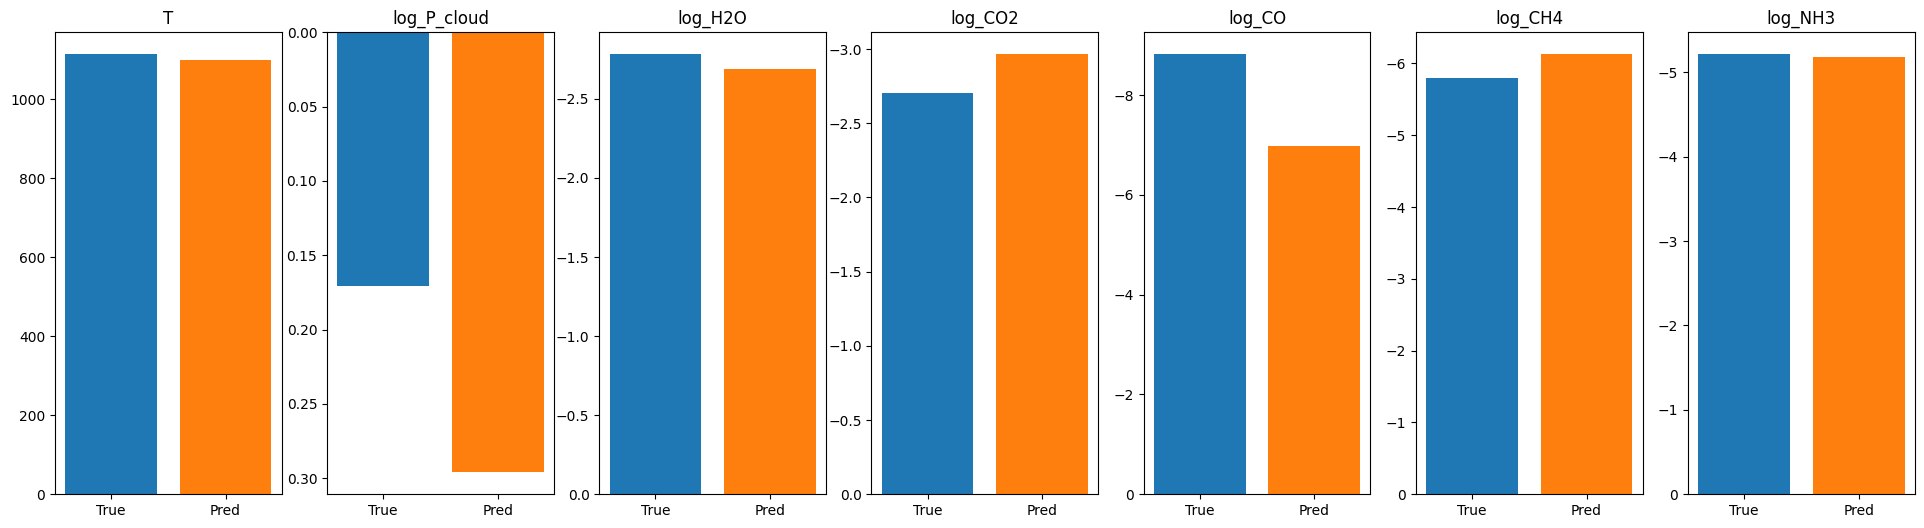

In [38]:
labels1 = ['True']
labels2 = ['Pred']
fig, axs = plt.subplots(1, 7, figsize=(24,6))

for i in range(7):
    if i > 0:
        axs[i].bar(labels1, planetB_params[3+i])
        axs[i].bar(labels2, planetB_pred[i])
        
        axs[i].set_title(keys[i])
        axs[i].invert_yaxis()
    else:
        axs[i].bar(labels1, planetB_params[3+i])
        axs[i].bar(labels2, planetB_pred[i])
        
        axs[i].set_title(keys[i])

In [39]:
planetC_pred = pred[2]
print("Predicted values:",planetC_pred)
print("Actual values:",planetC_params[3:])

Predicted values: [2630.8335      -3.4251595   -6.8741655   -5.459412    -7.308796
   -3.1494918   -6.9673505]
Actual values: [ 2.66055847e+03 -3.48554752e+00 -5.39606516e+00 -5.07833705e+00
 -5.97777151e+00 -2.57789940e+00 -5.33643891e+00]


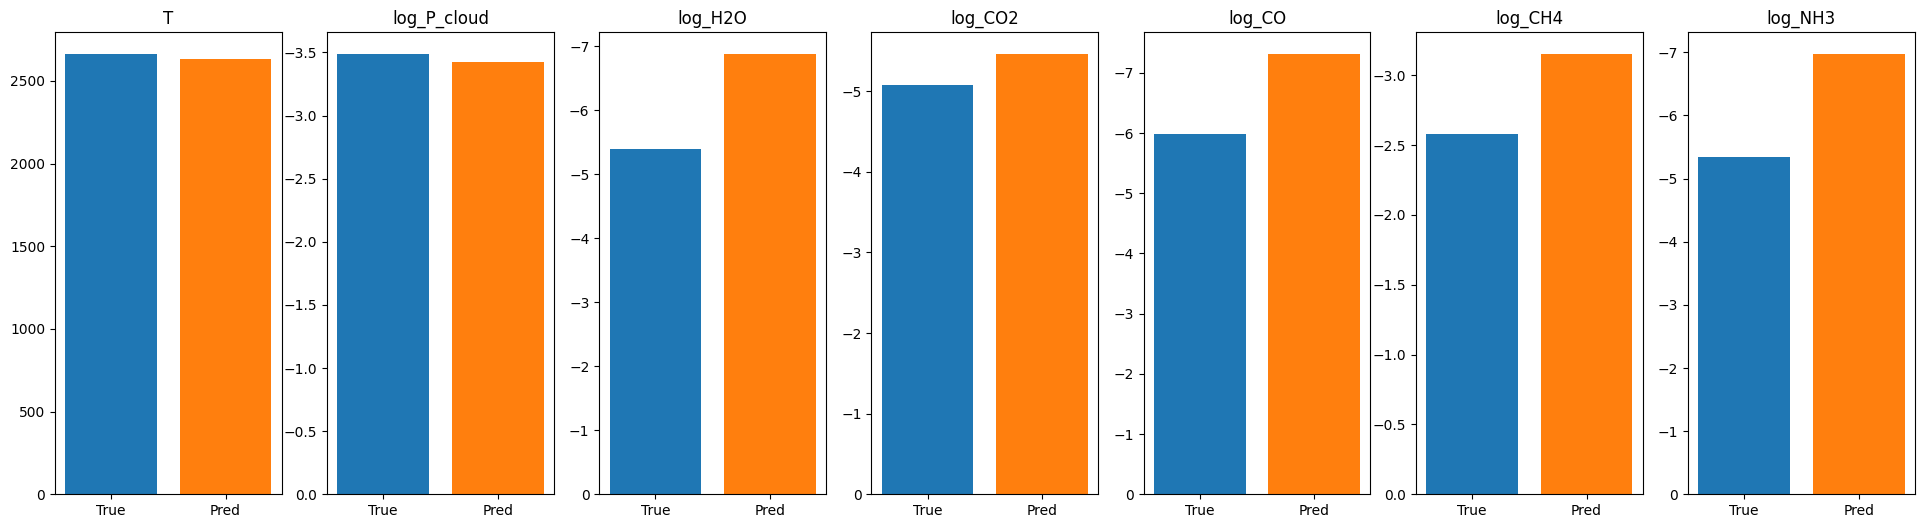

In [40]:
labels1 = ['True']
labels2 = ['Pred']
fig, axs = plt.subplots(1, 7, figsize=(24,6))

for i in range(7):
    if i > 0:
        axs[i].bar(labels1, planetC_params[3+i])
        axs[i].bar(labels2, planetC_pred[i])
        
        axs[i].set_title(keys[i])
        axs[i].invert_yaxis()
    else:
        axs[i].bar(labels1, planetC_params[3+i])
        axs[i].bar(labels2, planetC_pred[i])
        
        axs[i].set_title(keys[i])

---------------------------------